In [3]:
%pip install pyaudio

import tkinter as tk
from tkinter import ttk, messagebox
import pyaudio
import numpy as np
import wave
import threading
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import queue
import librosa
from scipy.signal import find_peaks

class AudioMonitor:
    def __init__(self, root):
        self.root = root
        self.root.title("Real-time Audio Monitor - Train Detection")
        self.root.geometry("1200x800")
        
        # Audio parameters
        self.CHUNK = 1024
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.RECORD_SECONDS = 10
        self.NUM_CLIPS = 4
        
        # Initialize PyAudio
        self.audio = pyaudio.PyAudio()
        self.stream = None
        
        # Data storage
        self.audio_data = np.zeros(self.CHUNK)
        self.frequencies = np.fft.fftfreq(self.CHUNK, 1/self.RATE)
        self.magnitude_spectrum = np.zeros(self.CHUNK//2)
        
        # Control variables
        self.is_monitoring = False
        self.is_recording = False
        self.threshold_hz = 1000  # Default threshold
        self.current_max_freq = 0
        self.train_detected = False
        
        # Recording storage
        self.recorded_clips = []
        self.recording_thread = None
        
        # Queue for thread-safe communication
        self.audio_queue = queue.Queue()
        
        # Setup GUI
        self.setup_gui()
        
        # Start audio processing
        self.start_monitoring()
    
    def setup_gui(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Control panel
        control_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        control_frame.grid(row=0, column=0, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Threshold setting
        ttk.Label(control_frame, text="Threshold (Hz):").grid(row=0, column=0, padx=(0, 5))
        self.threshold_var = tk.StringVar(value=str(self.threshold_hz))
        threshold_entry = ttk.Entry(control_frame, textvariable=self.threshold_var, width=10)
        threshold_entry.grid(row=0, column=1, padx=(0, 10))
        
        ttk.Button(control_frame, text="Update Threshold", 
                  command=self.update_threshold).grid(row=0, column=2, padx=(0, 20))
        
        # Status indicators
        self.status_label = ttk.Label(control_frame, text="Status: Monitoring")
        self.status_label.grid(row=0, column=3, padx=(0, 20))
        
        # Green/Red bulb indicator
        self.bulb_canvas = tk.Canvas(control_frame, width=50, height=50, bg='white')
        self.bulb_canvas.grid(row=0, column=4, padx=(0, 10))
        self.bulb = self.bulb_canvas.create_oval(10, 10, 40, 40, fill='green', outline='black', width=2)
        
        # Current frequency display
        self.freq_label = ttk.Label(control_frame, text="Current Peak: 0 Hz")
        self.freq_label.grid(row=1, column=0, columnspan=3, pady=(10, 0))
        
        # Recording status
        self.recording_label = ttk.Label(control_frame, text="Recording: No")
        self.recording_label.grid(row=1, column=3, columnspan=2, pady=(10, 0))
        
        # Waveform plot
        plot_frame = ttk.LabelFrame(main_frame, text="Real-time Audio Visualization", padding="10")
        plot_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), pady=(0, 10))
        
        # Create matplotlib figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(12, 8))
        self.fig.tight_layout(pad=3.0)
        
        # Waveform plot
        self.ax1.set_title("Audio Waveform")
        self.ax1.set_xlabel("Sample")
        self.ax1.set_ylabel("Amplitude")
        self.line1, = self.ax1.plot([], [], 'b-')
        self.ax1.set_xlim(0, self.CHUNK)
        self.ax1.set_ylim(-32768, 32767)
        
        # Frequency spectrum plot
        self.ax2.set_title("Frequency Spectrum")
        self.ax2.set_xlabel("Frequency (Hz)")
        self.ax2.set_ylabel("Magnitude")
        self.line2, = self.ax2.plot([], [], 'r-')
        self.ax2.set_xlim(0, self.RATE//2)
        self.ax2.set_ylim(0, 1000)
        
        # Threshold line
        self.threshold_line = self.ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Threshold')
        self.ax2.legend()
        
        # Embed plot in tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Log frame
        log_frame = ttk.LabelFrame(main_frame, text="Activity Log", padding="10")
        log_frame.grid(row=2, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Log text widget
        self.log_text = tk.Text(log_frame, height=8, width=80)
        scrollbar = ttk.Scrollbar(log_frame, orient="vertical", command=self.log_text.yview)
        self.log_text.configure(yscrollcommand=scrollbar.set)
        self.log_text.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        
        # Configure grid weights
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        main_frame.columnconfigure(0, weight=1)
        main_frame.rowconfigure(1, weight=1)
        log_frame.columnconfigure(0, weight=1)
        log_frame.rowconfigure(0, weight=1)
    
    def log_message(self, message):
        """Add message to log with timestamp"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.log_text.insert(tk.END, f"[{timestamp}] {message}\n")
        self.log_text.see(tk.END)
    
    def update_threshold(self):
        """Update threshold value"""
        try:
            new_threshold = float(self.threshold_var.get())
            self.threshold_hz = new_threshold
            self.log_message(f"Threshold updated to {new_threshold} Hz")
        except ValueError:
            messagebox.showerror("Error", "Please enter a valid number for threshold")
    
    def start_monitoring(self):
        """Start audio monitoring"""
        try:
            self.stream = self.audio.open(
                format=self.FORMAT,
                channels=self.CHANNELS,
                rate=self.RATE,
                input=True,
                frames_per_buffer=self.CHUNK
            )
            
            self.is_monitoring = True
            self.log_message("Audio monitoring started")
            
            # Start audio processing thread
            self.audio_thread = threading.Thread(target=self.audio_processing_loop, daemon=True)
            self.audio_thread.start()
            
            # Start GUI update timer
            self.update_gui()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to start audio monitoring: {str(e)}")
    
    def audio_processing_loop(self):
        """Main audio processing loop"""
        while self.is_monitoring:
            try:
                # Read audio data
                data = self.stream.read(self.CHUNK, exception_on_overflow=False)
                audio_data = np.frombuffer(data, dtype=np.int16)
                
                # Calculate frequency spectrum
                fft = np.fft.fft(audio_data)
                magnitude = np.abs(fft[:self.CHUNK//2])
                
                # Find peak frequency
                if np.max(magnitude) > 100:  # Noise threshold
                    peak_idx = np.argmax(magnitude)
                    peak_freq = self.frequencies[peak_idx]
                    if peak_freq > 0:
                        self.current_max_freq = peak_freq
                else:
                    self.current_max_freq = 0
                
                # Store data for GUI update
                self.audio_data = audio_data
                self.magnitude_spectrum = magnitude
                
                # Check threshold
                if self.current_max_freq > self.threshold_hz and not self.is_recording:
                    self.log_message(f"Threshold exceeded: {self.current_max_freq:.1f} Hz")
                    self.start_recording()
                
                # Reset train detection when below threshold
                if self.current_max_freq < self.threshold_hz and self.train_detected:
                    self.train_detected = False
                    self.log_message("Train detection reset - frequency below threshold")
                
                time.sleep(0.01)  # Small delay to prevent CPU overload
                
            except Exception as e:
                self.log_message(f"Audio processing error: {str(e)}")
                time.sleep(0.1)
    
    def start_recording(self):
        """Start recording 4 clips of 10 seconds each"""
        if self.is_recording:
            return
        
        self.is_recording = True
        self.recorded_clips = []
        self.log_message("Starting recording sequence...")
        
        # Start recording in separate thread
        self.recording_thread = threading.Thread(target=self.record_clips, daemon=True)
        self.recording_thread.start()
    
    def record_clips(self):
        """Record 4 clips of 10 seconds each"""
        try:
            for clip_num in range(self.NUM_CLIPS):
                self.log_message(f"Recording clip {clip_num + 1}/{self.NUM_CLIPS}")
                
                # Record audio
                frames = []
                for _ in range(0, int(self.RATE / self.CHUNK * self.RECORD_SECONDS)):
                    if not self.is_monitoring:
                        break
                    data = self.stream.read(self.CHUNK, exception_on_overflow=False)
                    frames.append(data)
                
                # Save clip
                filename = f"clip_{clip_num + 1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.wav"
                self.save_audio_clip(frames, filename)
                self.recorded_clips.append(filename)
                
                # Process with model
                is_train = self.process_with_model(filename)
                if is_train:
                    self.train_detected = True
                    self.log_message(f"Train detected in clip {clip_num + 1}")
                    break
                else:
                    self.log_message(f"No train detected in clip {clip_num + 1}")
                
                time.sleep(0.5)  # Small delay between clips
            
            self.is_recording = False
            self.log_message("Recording sequence completed")
            
        except Exception as e:
            self.log_message(f"Recording error: {str(e)}")
            self.is_recording = False
    
    def save_audio_clip(self, frames, filename):
        """Save audio frames to WAV file"""
        try:
            # Create recordings directory if it doesn't exist
            if not os.path.exists("recordings"):
                os.makedirs("recordings")
            
            filepath = os.path.join("recordings", filename)
            
            with wave.open(filepath, 'wb') as wf:
                wf.setnchannels(self.CHANNELS)
                wf.setsampwidth(self.audio.get_sample_size(self.FORMAT))
                wf.setframerate(self.RATE)
                wf.writeframes(b''.join(frames))
            
            self.log_message(f"Saved: {filename}")
            
        except Exception as e:
            self.log_message(f"Error saving {filename}: {str(e)}")
    
    def process_with_model(self, filename):
        """Process audio clip with model to detect train"""
        try:
            # Load audio file
            filepath = os.path.join("recordings", filename)
            y, sr = librosa.load(filepath, sr=self.RATE)
            
            # Simple train detection logic (replace with your actual model)
            # This is a placeholder - you would replace this with your trained model
            
            # Extract features
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            
            # Simple heuristic (replace with your model prediction)
            # Train sounds typically have:
            # - Lower frequency dominance
            # - More consistent spectral pattern
            # - Longer duration of sustained sound
            
            mean_spectral_centroid = np.mean(spectral_centroids)
            mfcc_var = np.var(mfcc)
            
            # Placeholder logic - replace with your actual model
            if mean_spectral_centroid < 2000 and mfcc_var > 10:
                return True  # Train detected
            else:
                return False  # No train
                
        except Exception as e:
            self.log_message(f"Model processing error for {filename}: {str(e)}")
            return False
    
    def update_gui(self):
        """Update GUI elements"""
        if not self.is_monitoring:
            return
        
        try:
            # Update waveform
            self.line1.set_data(range(len(self.audio_data)), self.audio_data)
            
            # Update frequency spectrum
            freqs = self.frequencies[:len(self.magnitude_spectrum)]
            self.line2.set_data(freqs, self.magnitude_spectrum)
            
            # Update threshold line position
            freq_at_threshold = self.threshold_hz
            max_mag = np.max(self.magnitude_spectrum) if len(self.magnitude_spectrum) > 0 else 1000
            self.threshold_line.set_ydata([max_mag * 0.8, max_mag * 0.8])
            
            # Update axis limits
            if len(self.magnitude_spectrum) > 0:
                self.ax2.set_ylim(0, max(np.max(self.magnitude_spectrum) * 1.1, 100))
            
            # Update frequency label
            self.freq_label.config(text=f"Current Peak: {self.current_max_freq:.1f} Hz")
            
            # Update recording status
            if self.is_recording:
                self.recording_label.config(text="Recording: Yes")
            else:
                self.recording_label.config(text="Recording: No")
            
            # Update bulb color
            if self.train_detected:
                self.bulb_canvas.itemconfig(self.bulb, fill='red')
            else:
                self.bulb_canvas.itemconfig(self.bulb, fill='green')
            
            # Redraw canvas
            self.canvas.draw_idle()
            
        except Exception as e:
            self.log_message(f"GUI update error: {str(e)}")
        
        # Schedule next update
        self.root.after(50, self.update_gui)  # Update every 50ms
    
    def cleanup(self):
        """Clean up resources"""
        self.is_monitoring = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.audio.terminate()
        self.log_message("Audio monitoring stopped")

def main():
    root = tk.Tk()
    app = AudioMonitor(root)
    
    # Handle window close
    def on_closing():
        app.cleanup()
        root.destroy()
    
    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()

if __name__ == "__main__":
    # Check required packages
    required_packages = ['pyaudio', 'numpy', 'matplotlib', 'librosa', 'scipy']
    missing_packages = []
    
    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            missing_packages.append(package)
    
    if missing_packages:
        print("Missing required packages:")
        print("pip install " + " ".join(missing_packages))
        exit(1)
    
    main()


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


: 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Recording to recordings/recording_20250710_090411_1.wav...
Saved recording to recordings/recording_20250710_090411_1.wav
Processing recording through model...
Recording to recordings/recording_20250710_090414_2.wav...
Saved recording to recordings/recording_20250710_090414_2.wav
Processing recording through model...
Recording to recordings/recording_20250710_090422_3.wav...
Saved recording to recordings/recording_20250710_090422_3.wav
Processing recording through model...
Recording to recordings/recording_20250710_090429_4.wav...
Saved recording to recordings/recording_20250710_090429_4.wav
Processing recording through model...


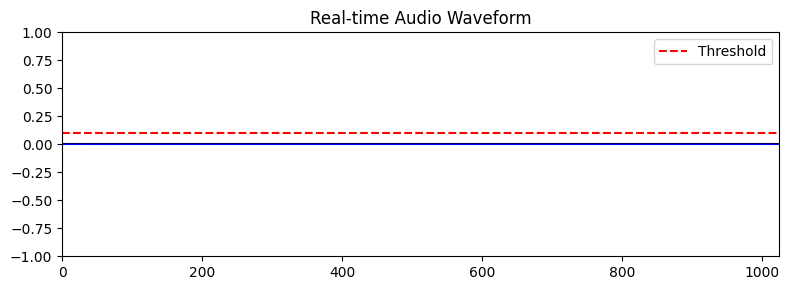

Exception in thread Thread-8 (process_audio):
Traceback (most recent call last):
  File "c:\Users\kavin\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\kavin\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\kavin\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kavin\AppData\Local\Temp\ipykernel_28012\942180163.py", line 145, in process_audio
  File "C:\Users\kavin\AppData\Local\Temp\ipykernel_28012\942180163.py", line 181, in process_audio_data
  File "c:\Users\kavin\AppData\Local\Programs\Python\Python311\Lib\tkinter\__init__.py", line 873, in after
    return self.tk.call('after', ms, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: main thread is not in main loop


In [2]:
%pip install sounddevice soundfile

import numpy as np
import sounddevice as sd
import soundfile as sf
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.fft import fft
import queue
import threading
import time
from datetime import datetime
import os

class AudioMonitorApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Audio Frequency Monitor")
        
        # Audio parameters
        self.sample_rate = 44100
        self.chunk_size = 1024
        self.recording_duration = 10  # seconds
        self.max_recordings = 4
        self.recording_count = 0
        
        # Frequency threshold
        self.threshold_freq = 1000  # Default threshold (1kHz)
        self.threshold_amplitude = 0.1  # Default amplitude threshold
        
        # Recording flags
        self.is_recording = False
        self.should_record = False
        self.recording_active = False
        self.above_threshold = False
        
        # Create GUI
        self.setup_gui()
        
        # Audio queue for thread communication
        self.audio_queue = queue.Queue()
        
        # Start audio stream
        self.stream = sd.InputStream(
            samplerate=self.sample_rate,
            channels=1,
            callback=self.audio_callback,
            blocksize=self.chunk_size
        )
        
        # Start processing thread
        self.processing_thread = threading.Thread(target=self.process_audio, daemon=True)
        self.processing_thread.start()
        
        # Start the stream
        self.stream.start()
        
        # Start the GUI update loop
        self.update_gui()
    
    def setup_gui(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Control panel
        control_frame = ttk.Frame(main_frame)
        control_frame.pack(fill=tk.X, pady=5)
        
        # Threshold controls
        ttk.Label(control_frame, text="Frequency Threshold (Hz):").grid(row=0, column=0, padx=5)
        self.threshold_entry = ttk.Entry(control_frame, width=10)
        self.threshold_entry.insert(0, str(self.threshold_freq))
        self.threshold_entry.grid(row=0, column=1, padx=5)
        
        ttk.Label(control_frame, text="Amplitude Threshold:").grid(row=0, column=2, padx=5)
        self.amplitude_entry = ttk.Entry(control_frame, width=10)
        self.amplitude_entry.insert(0, str(self.threshold_amplitude))
        self.amplitude_entry.grid(row=0, column=3, padx=5)
        
        set_threshold_btn = ttk.Button(control_frame, text="Set Threshold", command=self.set_threshold)
        set_threshold_btn.grid(row=0, column=4, padx=5)
        
        # Status indicator
        self.status_indicator = tk.Canvas(main_frame, width=30, height=30, bg="green")
        self.status_indicator.pack(pady=5)
        self.draw_indicator("green")
        
        # Recording info
        self.recording_label = ttk.Label(main_frame, text="Ready to monitor...")
        self.recording_label.pack(pady=5)
        
        # Waveform display
        self.setup_waveform_display(main_frame)
        
        # Model output
        model_frame = ttk.LabelFrame(main_frame, text="Model Output", padding="10")
        model_frame.pack(fill=tk.X, pady=5)
        
        self.model_output = ttk.Label(model_frame, text="No train detected")
        self.model_output.pack()
    
    def setup_waveform_display(self, parent):
        # Create matplotlib figure
        self.fig, self.ax = plt.subplots(figsize=(8, 3), tight_layout=True)
        self.ax.set_ylim(-1, 1)
        self.ax.set_xlim(0, self.chunk_size)
        self.ax.axhline(y=0, color='black', linestyle='-')
        self.threshold_line = self.ax.axhline(y=self.threshold_amplitude, color='red', linestyle='--', label='Threshold')
        self.wave_line, = self.ax.plot([], [], 'b-', lw=1)
        self.ax.legend()
        self.ax.set_title("Real-time Audio Waveform")
        
        # Embed in tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=parent)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    def draw_indicator(self, color):
        self.status_indicator.delete("all")
        self.status_indicator.create_oval(5, 5, 25, 25, fill=color, outline="black")
    
    def set_threshold(self):
        try:
            self.threshold_freq = float(self.threshold_entry.get())
            self.threshold_amplitude = float(self.amplitude_entry.get())
            self.threshold_line.set_ydata([self.threshold_amplitude, self.threshold_amplitude])
            self.canvas.draw()
        except ValueError:
            pass
    
    def audio_callback(self, indata, frames, time, status):
        if status:
            print(status)
        self.audio_queue.put(indata.copy())
    
    def process_audio(self):
        while True:
            try:
                audio_data = self.audio_queue.get_nowait()
                
                # Process audio data
                self.process_audio_data(audio_data)
                
                # Check if we should start recording
                if self.should_record and not self.is_recording and self.recording_count < self.max_recordings:
                    self.start_recording()
                
            except queue.Empty:
                time.sleep(0.01)
    
    def process_audio_data(self, audio_data):
        # Update waveform display
        self.wave_line.set_ydata(audio_data.flatten())
        self.wave_line.set_xdata(np.arange(len(audio_data)))
        self.canvas.draw()
        
        # Calculate FFT
        fft_result = np.abs(fft(audio_data.flatten()))
        freqs = np.fft.fftfreq(len(fft_result), 1/self.sample_rate)
        
        # Find dominant frequency
        dominant_idx = np.argmax(fft_result)
        dominant_freq = abs(freqs[dominant_idx])
        max_amplitude = np.max(np.abs(audio_data))
        
        # Check threshold
        if (dominant_freq > self.threshold_freq and 
            max_amplitude > self.threshold_amplitude and 
            not self.above_threshold):
            self.above_threshold = True
            self.should_record = True
            self.root.after(0, self.draw_indicator, "red")
            self.root.after(0, self.model_output.config, {"text": "Train detected!"})
        
        elif (dominant_freq <= self.threshold_freq or 
              max_amplitude <= self.threshold_amplitude):
            self.above_threshold = False
            self.root.after(0, self.draw_indicator, "green")
            self.root.after(0, self.model_output.config, {"text": "No train detected"})
    
    def start_recording(self):
        self.is_recording = True
        self.recording_count += 1
        self.root.after(0, self.recording_label.config, 
                       {"text": f"Recording {self.recording_count}/{self.max_recordings}..."})
        
        # Create output directory if it doesn't exist
        os.makedirs("recordings", exist_ok=True)
        
        # Generate filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"recordings/recording_{timestamp}_{self.recording_count}.wav"
        
        # Start recording in a separate thread
        threading.Thread(target=self.record_audio, args=(filename,)).start()
    
    def record_audio(self, filename):
        self.recording_active = True
        recording = []
        
        # Record for the specified duration
        print(f"Recording to {filename}...")
        for i in range(int(self.sample_rate / self.chunk_size * self.recording_duration)):
            try:
                audio_data = self.audio_queue.get_nowait()
                recording.append(audio_data.copy())
            except queue.Empty:
                time.sleep(self.chunk_size / self.sample_rate)
        
        # Save recording
        recording = np.concatenate(recording)
        sf.write(filename, recording, self.sample_rate)
        print(f"Saved recording to {filename}")
        
        # Process recording through model (simulated)
        self.process_recording(recording)
        
        # Update state
        self.is_recording = False
        self.recording_active = False
        
        if self.recording_count >= self.max_recordings:
            self.should_record = False
            self.root.after(0, self.recording_label.config, 
                           {"text": "Recording complete - 4 clips saved"})
        else:
            self.root.after(0, self.recording_label.config, 
                           {"text": f"Ready to record next clip ({self.recording_count}/{self.max_recordings})"})
    
    def process_recording(self, recording):
        # Simulate model processing
        # In a real application, you would pass the recording to your ML model here
        print("Processing recording through model...")
        time.sleep(1)  # Simulate processing time
    
    def update_gui(self):
        self.root.update()
        self.root.after(100, self.update_gui)
    
    def on_close(self):
        self.stream.stop()
        self.stream.close()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = AudioMonitorApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_close)
    root.mainloop()

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import pyaudio
import numpy as np
import wave
import threading
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import queue

class AudioMonitor:
    def __init__(self, root):
        self.root = root
        self.root.title("Real-time Audio Monitor - Train Detection")
        self.root.geometry("1200x800")
        
        # Audio parameters
        self.CHUNK = 1024
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.CLIP_DURATION = 10  # Duration of each clip in seconds
        self.TOTAL_RECORD_SECONDS = 40  # Total recording duration when train is detected
        
        # Initialize PyAudio
        self.audio = pyaudio.PyAudio()
        self.stream = None
        
        # Data storage
        self.audio_data = np.zeros(self.CHUNK)
        self.frequencies = np.fft.fftfreq(self.CHUNK, 1/self.RATE)
        self.magnitude_spectrum = np.zeros(self.CHUNK//2)
        
        # Control variables
        self.is_monitoring = False
        self.is_recording = False
        self.threshold_hz = 1000  # Default threshold
        self.current_max_freq = 0
        self.train_detected = False
        self.first_detection = False
        
        # Recording storage
        self.recorded_clips = []
        self.recording_thread = None
        
        # Queue for thread-safe communication
        self.audio_queue = queue.Queue()
        
        # Setup GUI first
        self.setup_gui()
        
        # Then load model (after GUI is ready)
        self.load_model()
        
        # Start audio processing
        self.start_monitoring()
    
    def load_model(self):
        """Load the pre-trained Keras model and scaler"""
        try:
            # Load the model from the root folder
            self.model = load_model('audio_train_classifier_model.h5')
            print("Model loaded successfully")  # Temporary console output
            
            # Initialize scaler (you should fit this with your training data)
            self.scaler = StandardScaler()
            
        except Exception as e:
            error_msg = f"Failed to load model: {str(e)}"
            print(error_msg)
            self.root.after(100, lambda: messagebox.showerror("Error", error_msg))
            self.root.after(1000, self.root.destroy)
    
    def setup_gui(self):
        """Set up the GUI components"""
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Control panel
        control_frame = ttk.LabelFrame(main_frame, text="Controls", padding="10")
        control_frame.grid(row=0, column=0, sticky=(tk.W, tk.E), pady=(0, 10))
        
        # Threshold setting
        ttk.Label(control_frame, text="Threshold (Hz):").grid(row=0, column=0, padx=(0, 5))
        self.threshold_var = tk.StringVar(value=str(self.threshold_hz))
        threshold_entry = ttk.Entry(control_frame, textvariable=self.threshold_var, width=10)
        threshold_entry.grid(row=0, column=1, padx=(0, 10))
        
        ttk.Button(control_frame, text="Update Threshold", 
                  command=self.update_threshold).grid(row=0, column=2, padx=(0, 20))
        
        # Status indicators
        self.status_label = ttk.Label(control_frame, text="Status: Monitoring")
        self.status_label.grid(row=0, column=3, padx=(0, 20))
        
        # Green/Red bulb indicator
        self.bulb_canvas = tk.Canvas(control_frame, width=50, height=50, bg='white')
        self.bulb_canvas.grid(row=0, column=4, padx=(0, 10))
        self.bulb = self.bulb_canvas.create_oval(10, 10, 40, 40, fill='green', outline='black', width=2)
        
        # Current frequency display
        self.freq_label = ttk.Label(control_frame, text="Current Peak: 0 Hz")
        self.freq_label.grid(row=1, column=0, columnspan=3, pady=(10, 0))
        
        # Recording status
        self.recording_label = ttk.Label(control_frame, text="Recording: No")
        self.recording_label.grid(row=1, column=3, columnspan=2, pady=(10, 0))
        
        # Waveform plot
        plot_frame = ttk.LabelFrame(main_frame, text="Real-time Audio Visualization", padding="10")
        plot_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S), pady=(0, 10))
        
        # Create matplotlib figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(12, 8))
        self.fig.tight_layout(pad=3.0)
        
        # Waveform plot
        self.ax1.set_title("Audio Waveform")
        self.ax1.set_xlabel("Sample")
        self.ax1.set_ylabel("Amplitude")
        self.line1, = self.ax1.plot([], [], 'b-')
        self.ax1.set_xlim(0, self.CHUNK)
        self.ax1.set_ylim(-32768, 32767)
        
        # Frequency spectrum plot
        self.ax2.set_title("Frequency Spectrum")
        self.ax2.set_xlabel("Frequency (Hz)")
        self.ax2.set_ylabel("Magnitude")
        self.line2, = self.ax2.plot([], [], 'r-')
        self.ax2.set_xlim(0, self.RATE//2)
        self.ax2.set_ylim(0, 1000)
        
        # Threshold line
        self.threshold_line = self.ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Threshold')
        self.ax2.legend()
        
        # Embed plot in tkinter
        self.canvas = FigureCanvasTkAgg(self.fig, master=plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Log frame
        log_frame = ttk.LabelFrame(main_frame, text="Activity Log", padding="10")
        log_frame.grid(row=2, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        
        # Log text widget
        self.log_text = tk.Text(log_frame, height=8, width=80)
        scrollbar = ttk.Scrollbar(log_frame, orient="vertical", command=self.log_text.yview)
        self.log_text.configure(yscrollcommand=scrollbar.set)
        self.log_text.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar.grid(row=0, column=1, sticky=(tk.N, tk.S))
        
        # Configure grid weights
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        main_frame.columnconfigure(0, weight=1)
        main_frame.rowconfigure(1, weight=1)
        log_frame.columnconfigure(0, weight=1)
        log_frame.rowconfigure(0, weight=1)
    
    def log_message(self, message):
        """Add message to log with timestamp"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.log_text.insert(tk.END, f"[{timestamp}] {message}\n")
        self.log_text.see(tk.END)
    
    def update_threshold(self):
        """Update threshold value"""
        try:
            new_threshold = float(self.threshold_var.get())
            self.threshold_hz = new_threshold
            self.log_message(f"Threshold updated to {new_threshold} Hz")
        except ValueError:
            messagebox.showerror("Error", "Please enter a valid number for threshold")
    
    def start_monitoring(self):
        """Start audio monitoring"""
        try:
            self.stream = self.audio.open(
                format=self.FORMAT,
                channels=self.CHANNELS,
                rate=self.RATE,
                input=True,
                frames_per_buffer=self.CHUNK
            )
            
            self.is_monitoring = True
            self.log_message("Audio monitoring started")
            
            # Start audio processing thread
            self.audio_thread = threading.Thread(target=self.audio_processing_loop, daemon=True)
            self.audio_thread.start()
            
            # Start GUI update timer
            self.update_gui()
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to start audio monitoring: {str(e)}")
    
    def audio_processing_loop(self):
        """Main audio processing loop"""
        while self.is_monitoring:
            try:
                # Read audio data
                data = self.stream.read(self.CHUNK, exception_on_overflow=False)
                audio_data = np.frombuffer(data, dtype=np.int16)
                
                # Calculate frequency spectrum
                fft = np.fft.fft(audio_data)
                magnitude = np.abs(fft[:self.CHUNK//2])
                
                # Find peak frequency
                if np.max(magnitude) > 100:  # Noise threshold
                    peak_idx = np.argmax(magnitude)
                    peak_freq = self.frequencies[peak_idx]
                    if peak_freq > 0:
                        self.current_max_freq = peak_freq
                else:
                    self.current_max_freq = 0
                
                # Store data for GUI update
                self.audio_data = audio_data
                self.magnitude_spectrum = magnitude
                
                # Check threshold
                if (self.current_max_freq > self.threshold_hz and 
                    not self.is_recording and 
                    not self.train_detected):
                    self.log_message(f"Threshold exceeded: {self.current_max_freq:.1f} Hz")
                    self.first_detection = True
                    self.start_recording()
                
                # Reset train detection when below threshold
                if self.current_max_freq < self.threshold_hz and self.train_detected:
                    self.train_detected = False
                    self.first_detection = False
                    self.log_message("Train detection reset - frequency below threshold")
                
                time.sleep(0.01)
                
            except Exception as e:
                self.log_message(f"Audio processing error: {str(e)}")
                time.sleep(0.1)
    
    def start_recording(self):
        """Start recording sequence"""
        if self.is_recording:
            return
        
        self.is_recording = True
        self.recorded_clips = []
        self.log_message("Starting recording sequence...")
        
        # Start recording in separate thread
        self.recording_thread = threading.Thread(target=self.record_train_sequence, daemon=True)
        self.recording_thread.start()
    
    def record_train_sequence(self):
        """Record 40 seconds total as four 10-second clips when train is first detected"""
        try:
            num_clips = self.TOTAL_RECORD_SECONDS // self.CLIP_DURATION
            
            for clip_num in range(num_clips):
                self.log_message(f"Recording clip {clip_num + 1}/{num_clips}")
                
                # Record audio
                frames = []
                for _ in range(0, int(self.RATE / self.CHUNK * self.CLIP_DURATION)):
                    if not self.is_monitoring:
                        break
                    data = self.stream.read(self.CHUNK, exception_on_overflow=False)
                    frames.append(data)
                
                # Save clip
                filename = f"clip_{clip_num + 1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.wav"
                self.save_audio_clip(frames, filename)
                self.recorded_clips.append(filename)
                
                # Process with model (only on first clip to confirm train)
                if clip_num == 0:
                    is_train = self.process_with_model(filename)
                    if is_train:
                        self.train_detected = True
                        self.log_message(f"Train confirmed in first clip - continuing recording")
                    else:
                        self.log_message("No train detected in first clip - stopping recording")
                        break
                
                time.sleep(0.5)  # Small delay between clips
            
            self.is_recording = False
            self.log_message("Recording sequence completed")
            
        except Exception as e:
            self.log_message(f"Recording error: {str(e)}")
            self.is_recording = False
    
    def save_audio_clip(self, frames, filename):
        """Save audio frames to WAV file"""
        try:
            if not os.path.exists("recordings"):
                os.makedirs("recordings")
            
            filepath = os.path.join("recordings", filename)
            
            with wave.open(filepath, 'wb') as wf:
                wf.setnchannels(self.CHANNELS)
                wf.setsampwidth(self.audio.get_sample_size(self.FORMAT))
                wf.setframerate(self.RATE)
                wf.writeframes(b''.join(frames))
            
            self.log_message(f"Saved: {filename}")
            
        except Exception as e:
            self.log_message(f"Error saving {filename}: {str(e)}")
    
    def extract_features(self, y, sr):
        """Extract audio features for model prediction"""
        features = []
        
        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        features.extend(mfcc_mean)
        
        # Spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features.extend([spectral_centroid, spectral_bandwidth, spectral_rolloff])
        
        # Zero crossing rate
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        features.append(zcr)
        
        # RMS energy
        rms = np.mean(librosa.feature.rms(y=y))
        features.append(rms)
        
        return np.array(features).reshape(1, -1)
    
    def process_with_model(self, filename):
        """Process audio clip with model to detect train"""
        try:
            filepath = os.path.join("recordings", filename)
            y, sr = librosa.load(filepath, sr=self.RATE)
            
            features = self.extract_features(y, sr)
            
            if hasattr(self.scaler, 'scale_'):
                features = self.scaler.transform(features)
            
            prediction = self.model.predict(features)
            
            is_train = prediction[0][0] > 0.5
            
            self.log_message(f"Model prediction: {'Train' if is_train else 'No train'} (confidence: {prediction[0][0]:.2f})")
            return is_train
            
        except Exception as e:
            self.log_message(f"Model processing error for {filename}: {str(e)}")
            return False
    
    def update_gui(self):
        """Update GUI elements"""
        if not self.is_monitoring:
            return
        
        try:
            self.line1.set_data(range(len(self.audio_data)), self.audio_data)
            
            freqs = self.frequencies[:len(self.magnitude_spectrum)]
            self.line2.set_data(freqs, self.magnitude_spectrum)
            
            max_mag = np.max(self.magnitude_spectrum) if len(self.magnitude_spectrum) > 0 else 1000
            self.threshold_line.set_ydata([max_mag * 0.8, max_mag * 0.8])
            
            if len(self.magnitude_spectrum) > 0:
                self.ax2.set_ylim(0, max(np.max(self.magnitude_spectrum) * 1.1, 100))
            
            self.freq_label.config(text=f"Current Peak: {self.current_max_freq:.1f} Hz")
            
            if self.is_recording:
                self.recording_label.config(text="Recording: Yes")
            else:
                self.recording_label.config(text="Recording: No")
            
            if self.train_detected:
                self.bulb_canvas.itemconfig(self.bulb, fill='red')
            else:
                self.bulb_canvas.itemconfig(self.bulb, fill='green')
            
            self.canvas.draw_idle()
            
        except Exception as e:
            self.log_message(f"GUI update error: {str(e)}")
        
        self.root.after(50, self.update_gui)
    
    def cleanup(self):
        """Clean up resources"""
        self.is_monitoring = False
        if self.stream:
            self.stream.stop_stream()
            self.stream.close()
        self.audio.terminate()
        self.log_message("Audio monitoring stopped")

def main():
    root = tk.Tk()
    app = AudioMonitor(root)
    
    def on_closing():
        app.cleanup()
        root.destroy()
    
    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()

if __name__ == "__main__":
    required_packages = [
        'pyaudio', 'numpy', 'matplotlib', 'librosa', 
        'tensorflow', 'scikit-learn', 'soundfile'
    ]
    missing_packages = []
    
    for package in required_packages:
        try:
            __import__(package)
        except ImportError:
            missing_packages.append(package)
    
    if missing_packages:
        print("Missing required packages:")
        print("pip install " + " ".join(missing_packages))
        exit(1)
    
    main()

Missing required packages:
pip install scikit-learn


Model loaded successfully


: 